In [10]:

# import tensorflow as tf


In [31]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras import losses

from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [4]:
# # reshape to (28, 28, 1) and normalize input images

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
# network parameters

input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 2 

# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [6]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
x = Conv2D(filters=32,kernel_size=kernel_size,activation='relu',strides=2,padding='same',name='conv_32_enc')(x)
x = Conv2D(filters=64,kernel_size=kernel_size,activation='relu',strides=2,padding='same',name='conv_64_enc')(x)
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='Encoder')
encoder.summary()               


Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv_32_enc (Conv2D)        (None, 14, 14, 32)        320       
                                                                 
 conv_64_enc (Conv2D)        (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 2)                 6274      
                                                                 
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


In [7]:
shape = encoder.get_layer('conv_64_enc').output_shape
shape

(None, 7, 7, 64)

In [8]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
x = Conv2DTranspose(filters=64,kernel_size=kernel_size,activation='relu',strides=2,padding='same')(x)
x = Conv2DTranspose(filters=32,kernel_size=kernel_size,activation='relu',strides=2,padding='same')(x)


# reconstruct the input
outputs = Conv2DTranspose(filters=1,kernel_size=kernel_size,activation='sigmoid',padding='same',name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

In [9]:
# will work in colab or just install needed pakages
# plot_model(encoder,to_file='models_images/encoder.png',show_shapes=True)


In [10]:
#the same as past cell
#plot_model(decoder,to_file='models_images/encoder.png',show_shapes=True)

In [11]:
autoencoder = Model(inputs,decoder(encoder(inputs)),name='autoencoder')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 2)                 25090     
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 90,179
Trainable params: 90,179
Non-trainable params: 0
_________________________________________________________________


In [12]:
# plot_model(autoencoder,to_file='models_images/autoencoder.png',show_shapes=True)

In [13]:
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train,x_train,validation_data=(x_test, x_test),epochs=1,batch_size=batch_size)

1875/1875 [==============================] - 11s 4ms/step - loss: 0.0545 - val_loss: 0.0493


In [14]:
x_decoded = autoencoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [15]:
x_decoded 


array([[[[4.31920961e-03],
         [9.22661740e-04],
         [4.59983508e-04],
         ...,
         [7.58013513e-04],
         [7.06293155e-04],
         [3.88035644e-03]],

        [[6.95097609e-04],
         [4.09652675e-05],
         [7.83247651e-06],
         ...,
         [2.72651123e-05],
         [1.45190743e-05],
         [2.32941442e-04]],

        [[3.26834677e-04],
         [2.70957225e-05],
         [6.99621478e-06],
         ...,
         [2.12378236e-05],
         [8.38428423e-06],
         [2.09152931e-04]],

        ...,

        [[3.46823974e-04],
         [1.54873305e-05],
         [3.40694169e-06],
         ...,
         [2.66423649e-06],
         [3.95448660e-06],
         [9.00228333e-05]],

        [[4.32861038e-04],
         [3.89159286e-05],
         [9.39209167e-06],
         ...,
         [1.33860649e-05],
         [1.15783978e-05],
         [2.66102870e-04]],

        [[1.72329217e-03],
         [2.79870816e-04],
         [8.19322886e-05],
         ...,
 

In [16]:
x_decoded.shape

(10000, 28, 28, 1)

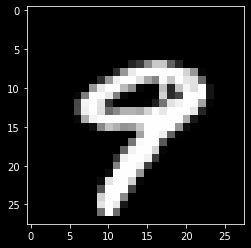

In [17]:
plt.imshow(x_test[9], cmap='gray')
plt.show()

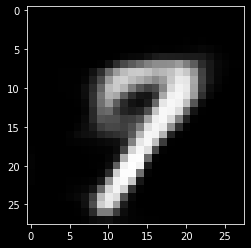

In [18]:
plt.imshow(x_decoded[9], cmap='gray')
plt.show()

# second auto encoder model for real problem 

In [33]:
# again
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 229s 52us/step


In [34]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


## add some noise to data ==> Image denoising

In [35]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

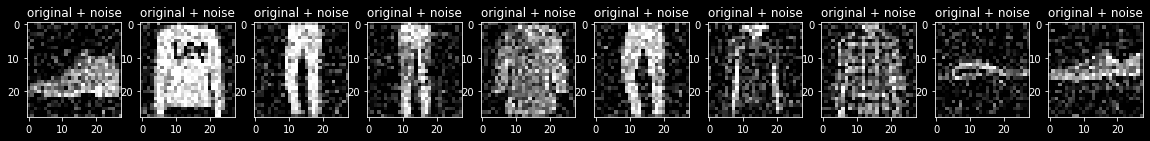

In [36]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [37]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(28, 28, 1)),
      Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [38]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [39]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0193 - val_loss: 0.0113
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.007

In [45]:
autoencoder.decoder.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [46]:
autoencoder.encoder.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [47]:
autoencoder.summary()

Model: "denoise_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 7, 7, 8)           1320      
                                                                 
 sequential_5 (Sequential)   (None, 28, 28, 1)         1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [43]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

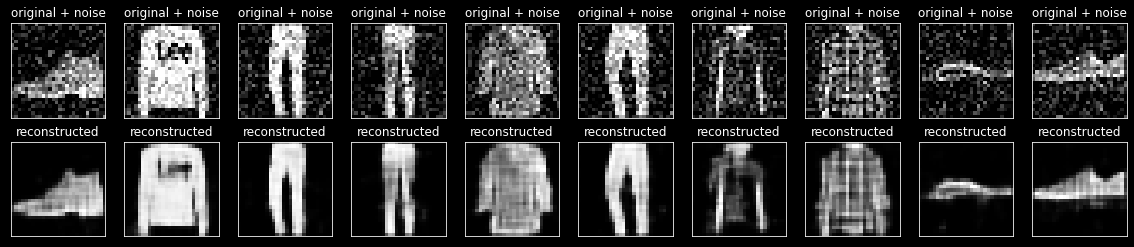

In [44]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# real Test

In [49]:
# again
(x_train00, _), (x_test00, _) = mnist.load_data()

In [50]:
noise_factor = 0.2
x_test_noisy = x_test00 + noise_factor * tf.random.normal(shape=x_test00.shape) 

x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

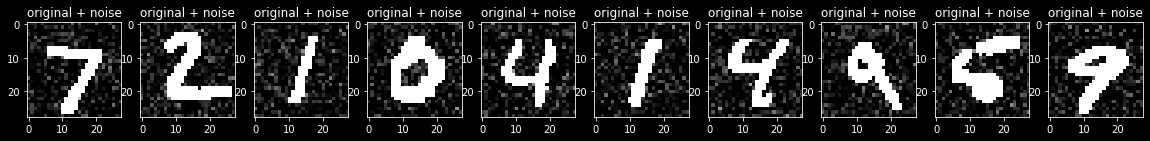

In [51]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [52]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

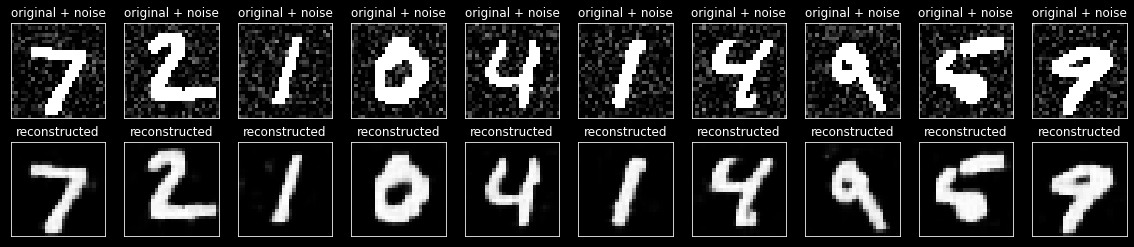

In [53]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()